### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing resident population in California data

In [3]:
# Importing Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = '6tQrxN5h2cAYbYMjg2PF'

In [5]:
# Importing the Resident Population in California Data variable
# For my project, all customers are located in California, USA

data = quandl.get('FRED/CAPOP')

In [6]:
data.head()

,Value
Date,
1900-01-01,1490.0
1901-01-01,1550.0
1902-01-01,1623.0
1903-01-01,1702.0
1904-01-01,1792.0


In [7]:
data.shape

(122, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [12]:
data.describe()

,Value
count,122.000000
mean,17774.315443
std,12908.577057
min,1490.000000
25%,5739.250000
50%,16183.500000
75%,30298.113250
max,39499.738000


In [13]:
type(data)

pandas.core.frame.DataFrame

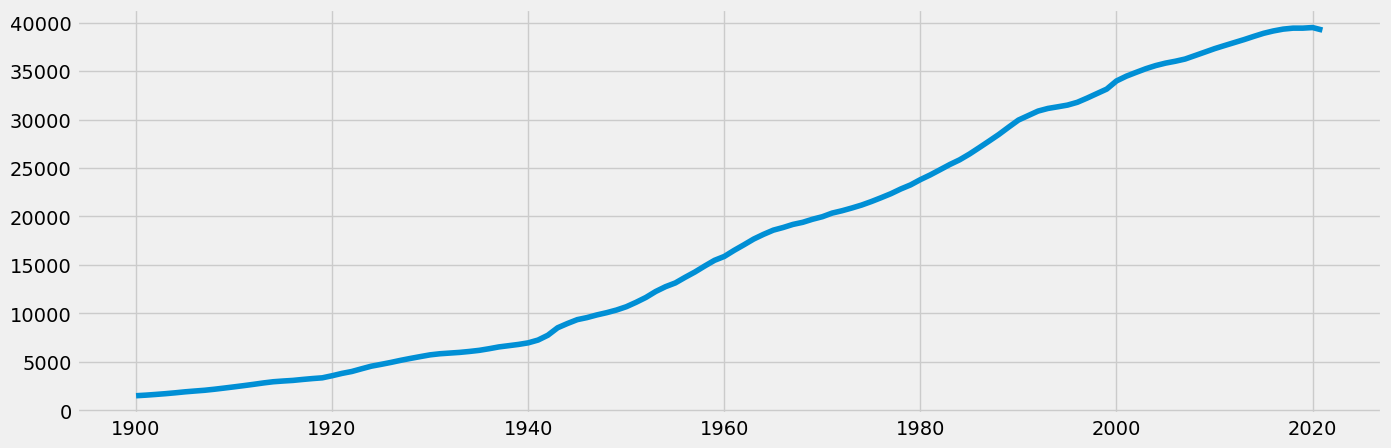

In [14]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

plt.show()

### 2. Subsetting, wrangling, and cleaning time-series data

In [17]:
# reset index
data2 = data.reset_index()

In [18]:
data2.head()

,Date,Value
0,1900-01-01,1490.0
1,1901-01-01,1550.0
2,1902-01-01,1623.0
3,1903-01-01,1702.0
4,1904-01-01,1792.0


In [22]:
print(data2['Date'].min())
print(data2['Date'].max())

1900-01-01 00:00:00
2021-01-01 00:00:00


In [74]:
# subset of dates
# Population data needed for recent time series
data_sub = data2.loc[(data2['Date'] >= '1980-01-01') & (data2['Date'] < '2021-01-01')]

Subset created for resident populations in California. LD&W has not been in operations for the entirety of this time series data and therefore would not be interested in time series data for the early to mid 1900s.

In [24]:
data_sub.shape

(41, 2)

In [25]:
data_sub.head()

,Date,Value
80,1980-01-01,23800.800
81,1981-01-01,24285.933
82,1982-01-01,24820.009
83,1983-01-01,25360.026
84,1984-01-01,25844.393


In [26]:
from datetime import datetime

data_sub['datetime'] =pd.to_datetime(data_sub['Date'])
data_sub.set_index('datetime',inplace = True)
data_sub.drop(columns = 'Date', inplace = True)
data_sub.head()

,Value
datetime,
1980-01-01,23800.800
1981-01-01,24285.933
1982-01-01,24820.009
1983-01-01,25360.026
1984-01-01,25844.393


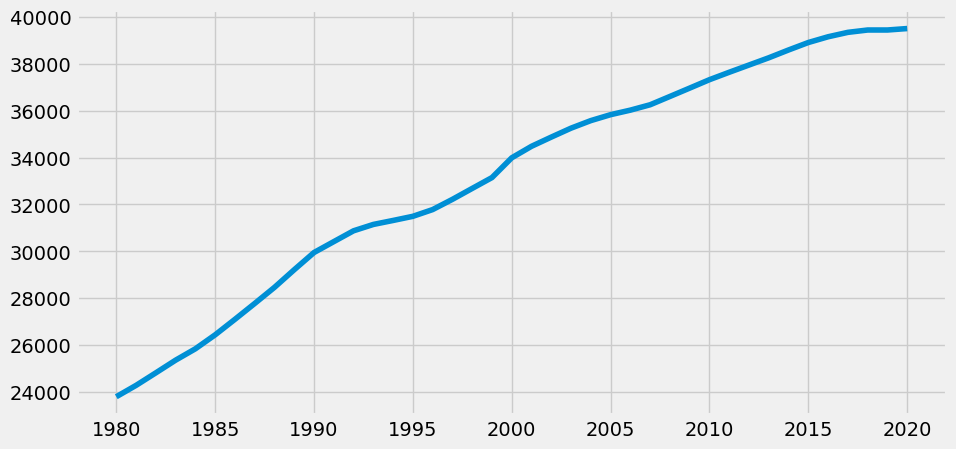

In [31]:
plt.figure(figsize = (10,5), dpi=100)

plt.plot(data_sub)

plt.show()

In [32]:
# missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [55]:
# duplicate check

dup = data_sub.duplicated()
dup.shape # no dups

(41,)

### 3. Time-series analysis: decomposition

In [56]:
# decompose the time series using additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model = 'additive')

In [57]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

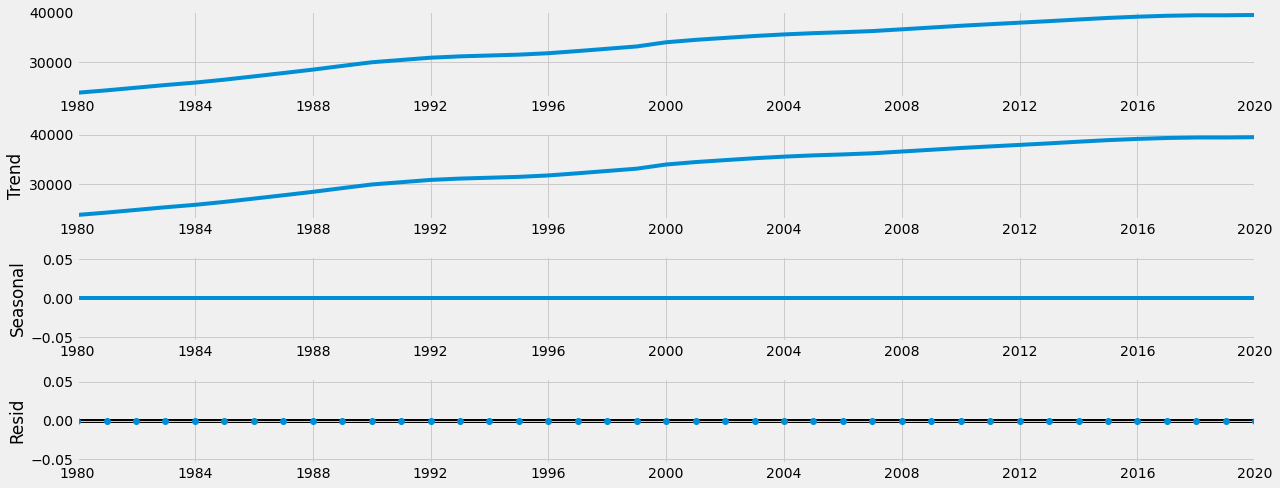

In [58]:
# plot the separate components

decomposition.plot()

plt.show()

### 4. Testing for Stationarity

In [59]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -4.316813
p-value                         0.000415
Number of Lags Used             6.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


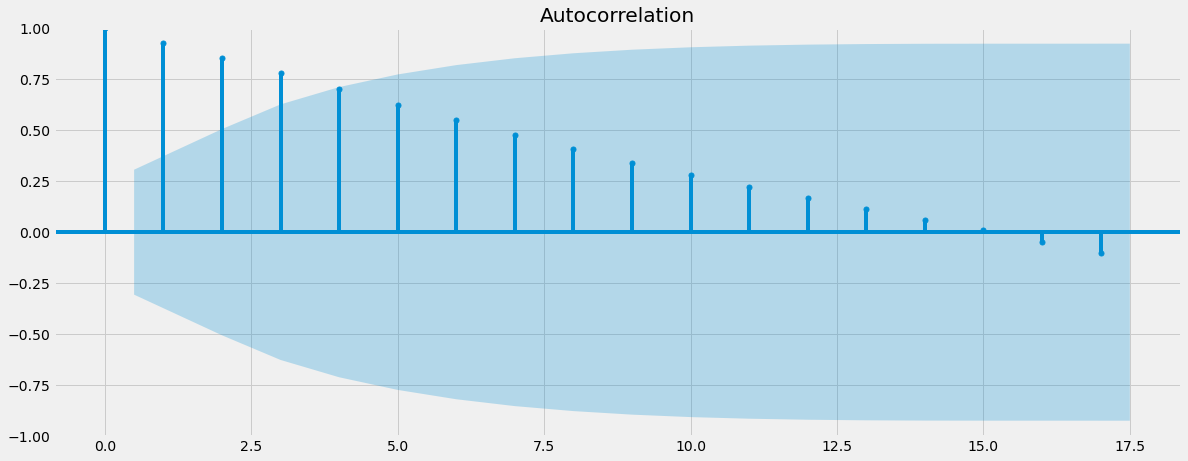

In [60]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the resident population in CA data

In [61]:
data_diff = data_sub - data_sub.shift(1)
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [62]:
data_diff.isnull().sum()

Value    1
dtype: int64

In [70]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

print(data_diff.isnull().sum())
print(data_diff.shape)
print(data_diff.columns)

Value    0
dtype: int64
(40, 1)
Index(['Value'], dtype='object')


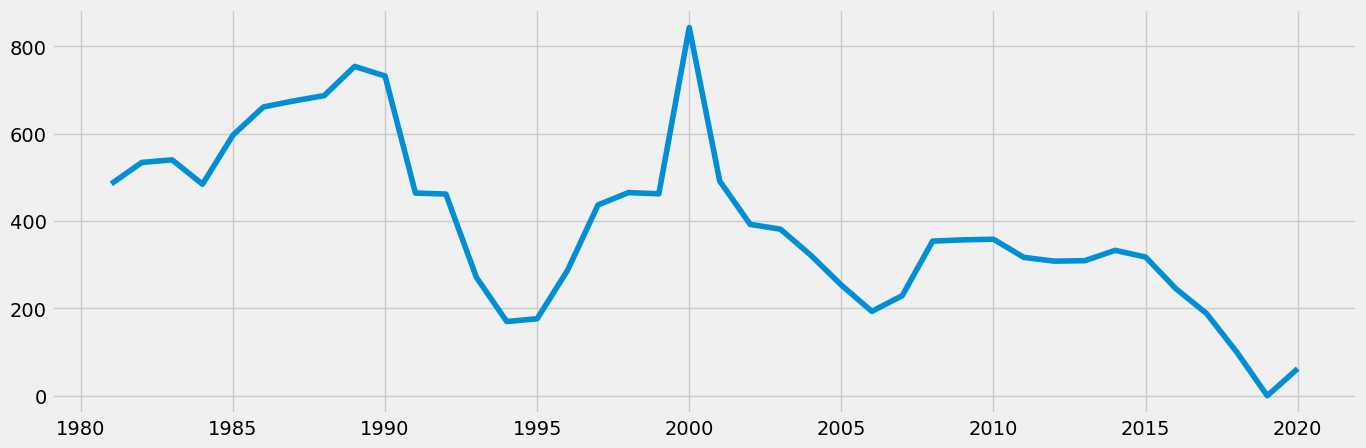

In [71]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [72]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.544487
p-value                         0.511401
Number of Lags Used             0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


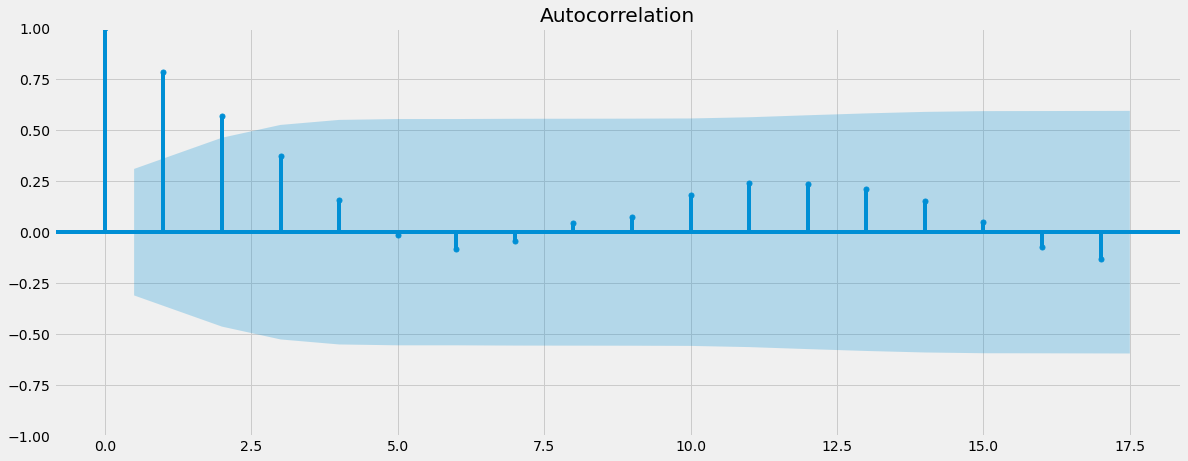

In [73]:
plot_acf(data_diff)
plt.show()

In [75]:
# Data is not statinary - perform another round of differencing on 

data_diff2 = data_diff - data_diff.shift(1)

In [76]:
data_diff2.isnull().sum()

Value    1
dtype: int64

In [77]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

print(data_diff2.isnull().sum())
print(data_diff2.shape)
print(data_diff2.columns)

Value    0
dtype: int64
(39, 1)
Index(['Value'], dtype='object')


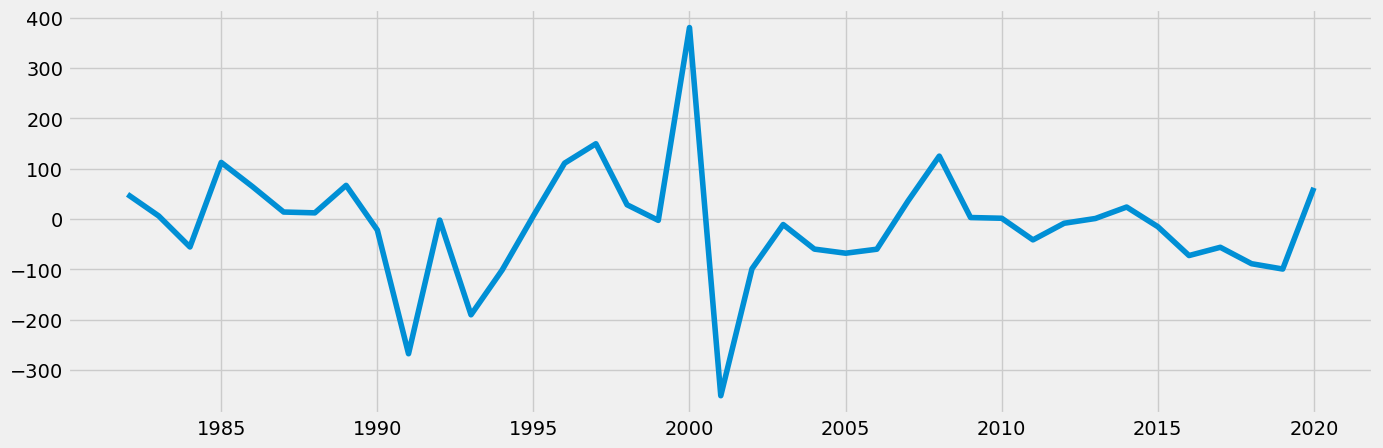

In [78]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [79]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.890748
p-value                         0.000036
Number of Lags Used             6.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


#### Test statistic is now smaller than the critical value at both the five and ten percent significance levels. Also have a satisfactory p-value (p<0.05). This means we can reject the null hypothesis and, as a result, consider the series stationary.

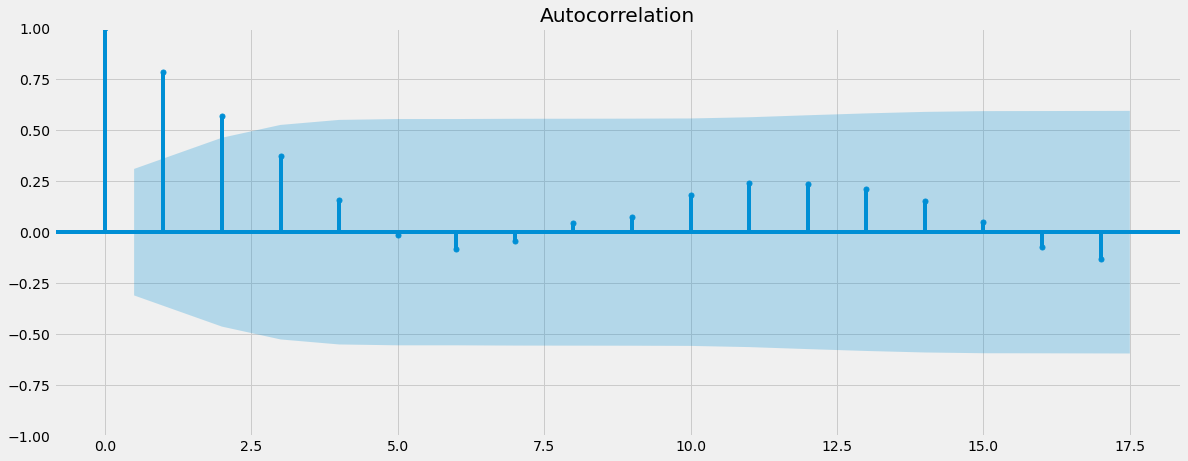

In [80]:
plot_acf(data_diff)
plt.show()